# Set Environment
Import the libaries need to handle html formats and data tables

In [103]:
import pandas as pd # used to handle dataframes/tables
import numpy as np # scientific computing python library
# used to make plots
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
# for categorical types
from pandas.api.types import CategoricalDtype

# Calling regions of artificial signal in ChIP-Seq
In the following notebook we create plots to show the effects masking blacklist (bl) and greenscreen (gs) regions in ChIP-seq. We tests both the number of inputs needed to define these regions as well as the type of inputs. We compare random inputs (of which we have 20 total) and inputs from one of the experiments (4 inputs from Zhu 2020).   
Note that the blacklist tool is hard-coded to find blacklist regions in the human genome. Therefore, to account for Arabidopsis having a smaller genome, the line of code that merges significant regions together had to be manually modified to merge regions within 5kb rather than 20kb. 

Greenscreen regions were generated by first running each input sample through MACS2 v2.2.7.1 (—keepdup “auto” —no model –extsize [read length] —broad --nolambda  -g 101274395). Peaks with average q-values (column 9 in the broadPeak output file) above 10-10 were filtered out. Peaks called from the individual inputs were concatenated, and all peaks within a 5kb distance were merged.

In [104]:
# file path to table
table_file="../data/callArtifSignalMetrics.tsv"
# read in table
table_df = pd.read_csv(table_file, sep="\t")

I want to give the AS mask type an a categorical order. It will make plotting easier.

In [105]:
asmask_category= CategoricalDtype(categories=["None","greenscreen","blacklist",], ordered=True)
table_df["AS_mask_type"] = table_df["AS_mask_type"].astype(asmask_category)
table_df.sort_values("AS_mask_type", inplace=True, na_position='first')

In [106]:
table_df.columns

Index(['AS_mask_type', 'average_MACS2_qvalue', 'merge_distance',
       'num_inputs_used', 'num_inputs_available', 'min_samples_called',
       'inputs_used', 'genome_cov', '100per_genes_coverage',
       'perc_lfy_chipseq_in_chipchip', 'c(Yk=2, Y’k=2)', 'c(Yk=3, Y’k=3)',
       'c(Zk=4, Z’k=4)'],
      dtype='object')

Also let's add numeric data types to some of the columns

In [107]:
numeric_cols=(['average_MACS2_qvalue','merge_distance'] +
              ['num_inputs_used', 'num_inputs_available'] + 
              ['min_samples_called', 'genome_cov'] +
              ['100per_genes_coverage'] + 
              ['perc_lfy_chipseq_in_chipchip'] + 
              ["c(Yk=2, Y’k=2)", "c(Yk=3, Y’k=3)"] + 
              ["c(Zk=4, Z’k=4)"])
for ncol in numeric_cols:
    if ncol in ["genome_cov"]:
        table_df[ncol] = pd.to_numeric(
            table_df[ncol].astype('str').str.replace(',', ''))
    elif ncol=="perc_lfy_chipseq_in_chipchip":
        table_df[ncol] = pd.to_numeric(
            table_df[ncol].astype('str').str.replace('%', ''))
        table_df[ncol] = table_df[ncol]/100
    else:
        table_df[ncol] = pd.to_numeric(table_df[ncol])

# number of Inputs
First let us look at how the number of inputs changes the downstream analysis of ChIP-seq. First we subset our table to only include rows where AS regions were generated from pulling out of the 20 random inputs (and as a control we include the row with metrics based on no mask). We also do not want to include AS regions generated using all 20 inputs.

In [108]:
ninputs_df = table_df.loc[(
    (table_df["num_inputs_available"]==20) & 
    (table_df["num_inputs_used"]!=20)),:]
ninputs_df.head()

,AS_mask_type,average_MACS2_qvalue,merge_distance,num_inputs_used,num_inputs_available,min_samples_called,inputs_used,genome_cov,100per_genes_coverage,perc_lfy_chipseq_in_chipchip,"c(Yk=2, Y’k=2)","c(Yk=3, Y’k=3)","c(Zk=4, Z’k=4)"
0,None,NaN,NaN,0,20,NaN,NaN,0,0,0.4057,0.56,0.59,0.73
33,greenscreen,10.0,5000.0,4,20,2.0,"A,E,F,T",434928,85,0.4226,1.00,0.84,1.00
34,greenscreen,10.0,5000.0,4,20,2.0,"A,O,P,R",359887,83,0.4201,0.83,0.92,0.83
35,greenscreen,10.0,5000.0,4,20,2.0,"E,G,L,O",470499,87,0.4226,1.00,0.84,1.00
36,greenscreen,10.0,5000.0,6,20,3.0,"C,M,N,O,R,S",376908,83,0.4203,1.00,0.84,1.00


Masking of peaks called because of artificial signal remove false positive peaks and allows for clustering of samples that has more to do with the biology. We measure how close two and three clusters resemble what we expect based on the biology using rand-index values (columns `trueClusters_k2` and `trueClusters_k3`). We want to visualize how the number of inputs changes these rand-index metrics in both the blacklist and green screen pipeline.

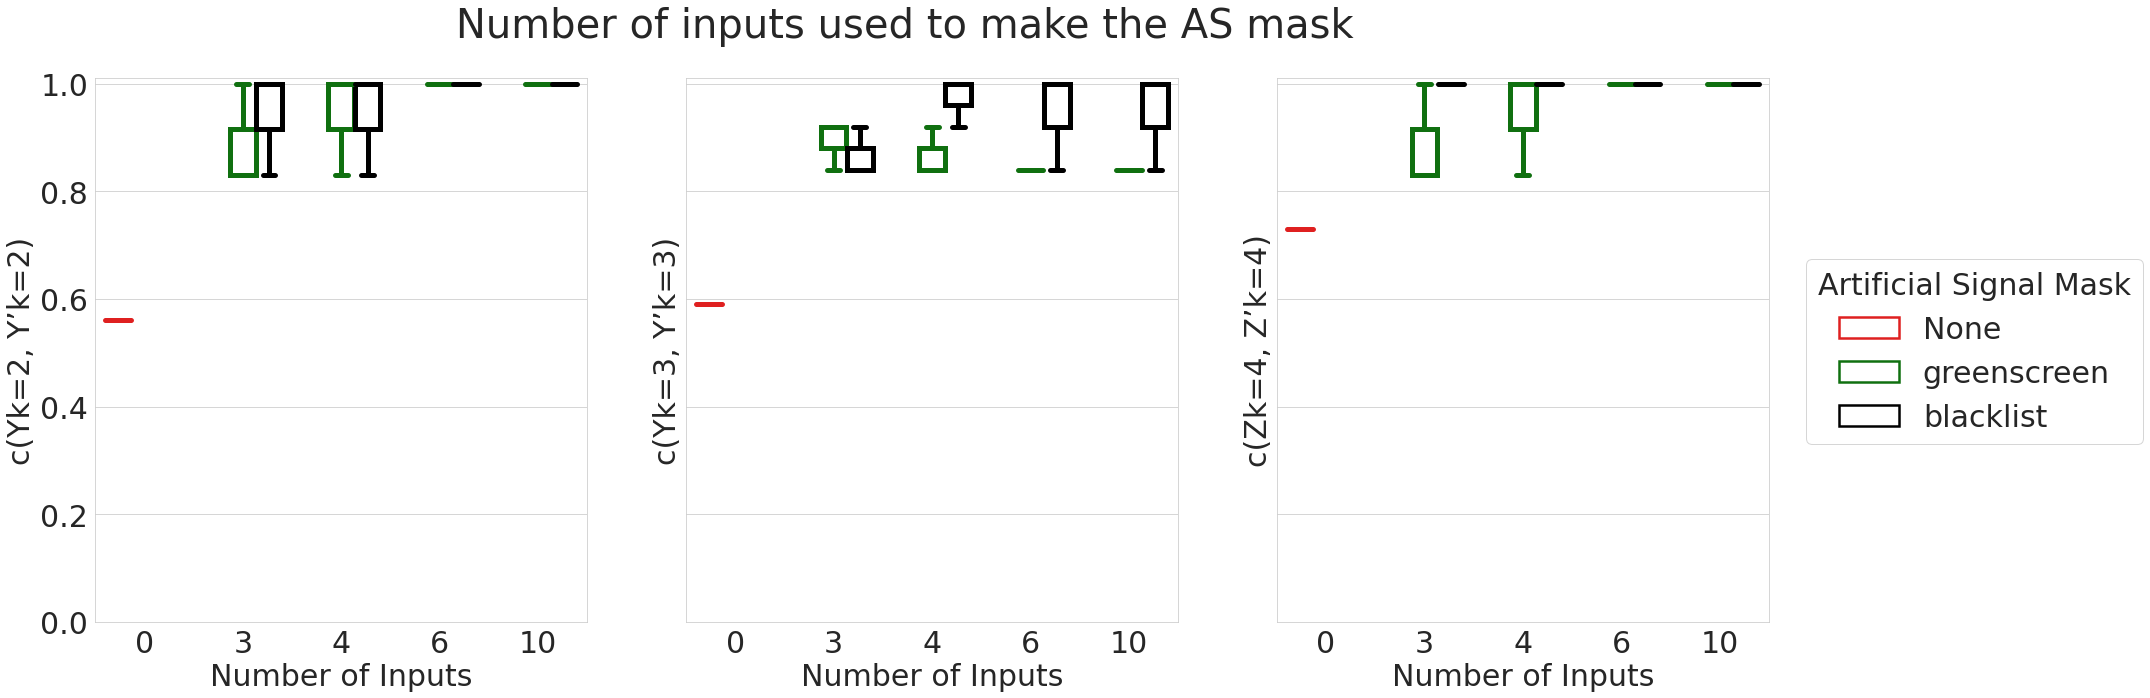

In [109]:
font = {'size'   : 30}

plt.rc('font', **font)


edge_width=5

fig, axs = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
sns.boxplot(x="num_inputs_used", 
            y="c(Yk=2, Y’k=2)",
            hue="AS_mask_type",
            palette=sns.color_palette(["red","green","black"]),
            linewidth = edge_width,
            data=ninputs_df, ax=axs[0])

sns.boxplot(x="num_inputs_used", 
            y="c(Yk=3, Y’k=3)",
            hue="AS_mask_type",
            palette=sns.color_palette(["red","green","black"]),
            linewidth = edge_width,
            data=ninputs_df, ax=axs[1])
sns.boxplot(x="num_inputs_used", 
            y="c(Zk=4, Z’k=4)",
            hue="AS_mask_type",
            palette=sns.color_palette(["red","green","black"]),
            linewidth = edge_width,
            data=ninputs_df, ax=axs[2])
for ax_i in range(0,3):
    for i,artist in enumerate(axs[ax_i].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = axs[ax_i].lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

#axs[0].set_ylabel('rand-index|k=2')
#axs[1].set_ylabel('rand-index|k=3')
#axs[2].set_ylabel('rand-index|k=4')
axs[0].set_xlabel('Number of Inputs')
axs[1].set_xlabel('Number of Inputs')
axs[2].set_xlabel('Number of Inputs')
fig.suptitle('Number of inputs used to make the AS mask',fontsize=40)

# set y limits
axs[0].set(ylim=(0, 1.01))
axs[1].set(ylim=(0, 1.01))
axs[2].set(ylim=(0, 1.01))


handles, labels = axs[2].get_legend_handles_labels()

axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()

# Also fix the legend
for legpatch in handles:
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')

fig.legend(handles, labels, loc='center right', 
           bbox_to_anchor=(1.08, .5), ncol=1, 
           title='Artificial Signal Mask')
plt.show()

# type of Inputs
Next let us look at how the types of inputs changes the downstream analysis of ChIP-seq. In other words, is better to use diverse inputs (not necessarily from the same experiment) or are inputs from the same experiment actually better? So that our variance is due to the inputs from a pool of the same size we look a groups of 3 inputs given a pool of 4 inputs. To represents inputs from the same experiment we look at 4 groups of 3 given the 4 inputs from Zhu 2020. To represent inputs from different experiments we look at 4 groups of 3 given 4 random inputs (samples E,G,L, and O).

In other words, we subset our table to only the control (no mask) and rows where AS regions were generated from pulling out of 4 inputs.

In [110]:
inputType_df = table_df.loc[(
    (table_df["num_inputs_available"]==4) | 
    (table_df["num_inputs_used"]==0)),:].copy()

inputType_df.loc[:,"Inputs for AS come from one of the ChIP experiments"] = (
    np.where(inputType_df['inputs_used'].str.contains('TFL1') , "match", "random")
)
#inputType_df.loc[:,"Inputs for AS come from one of the ChIP experiments"].replace(
#    {True: "match", False: "random"}, inplace=True)
inputType_df.loc[inputType_df["inputs_used"].isna(),"Inputs for AS come from one of the ChIP experiments"]="random"

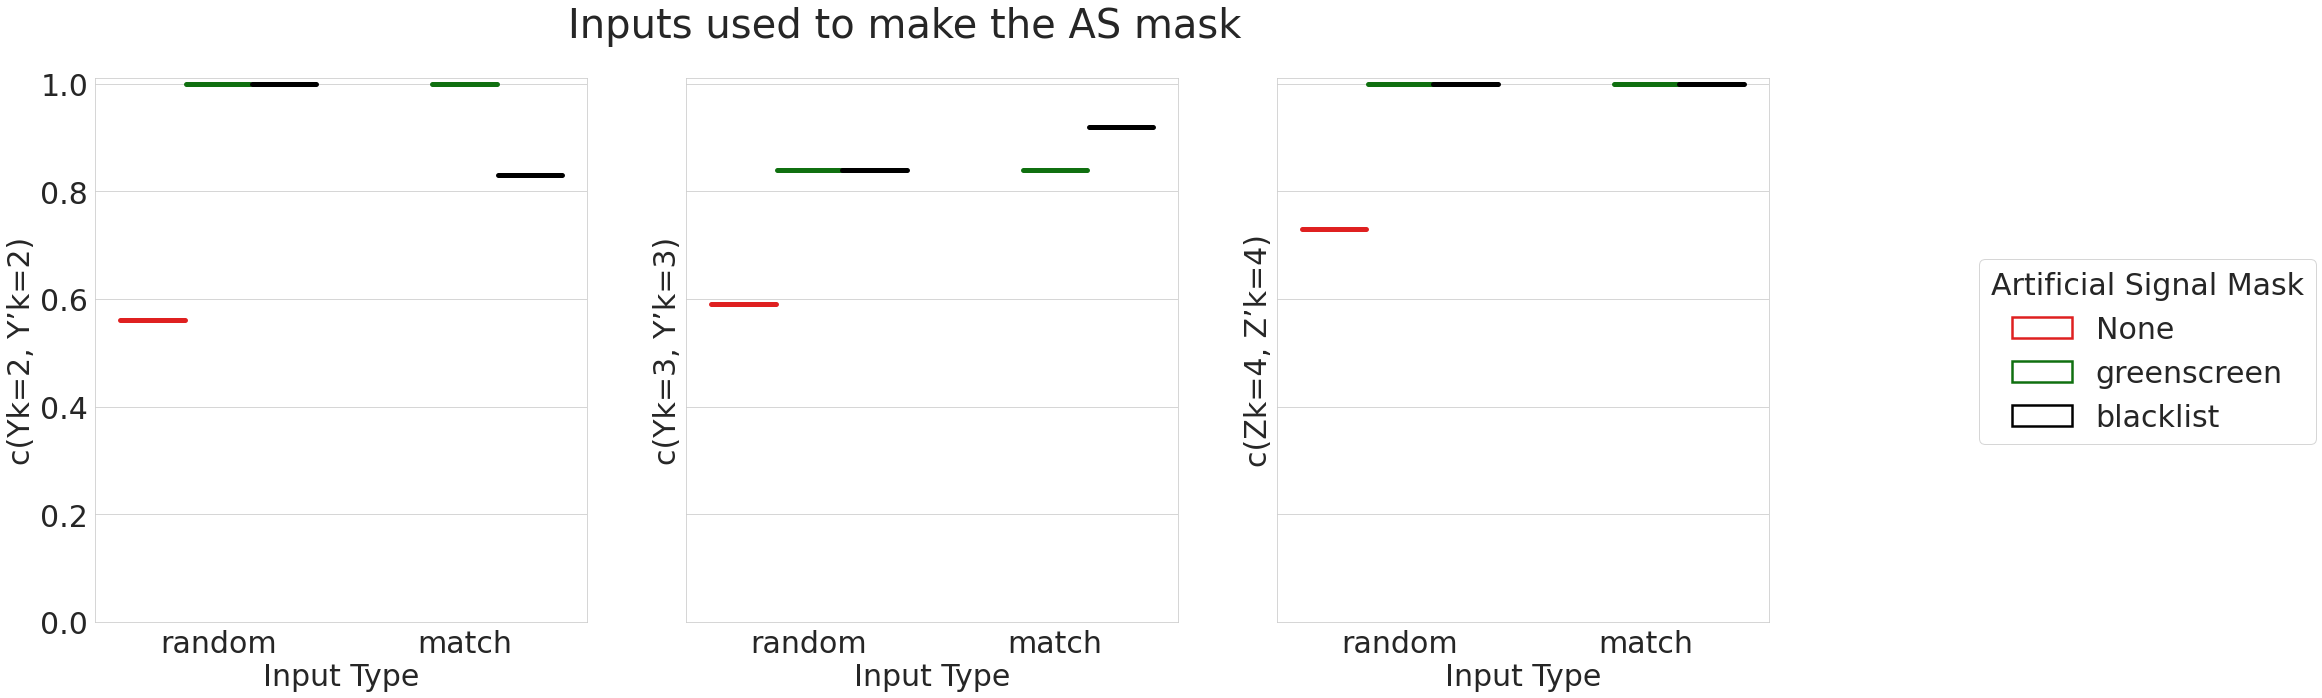

In [111]:
font = {'size'   : 30}

plt.rc('font', **font)

edge_width=5

fig, axs = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
sns.boxplot(x="Inputs for AS come from one of the ChIP experiments", 
            y="c(Yk=2, Y’k=2)",
            hue="AS_mask_type",
            palette=sns.color_palette(["red","green","black"]),
            linewidth = edge_width,
            data=inputType_df, ax=axs[0])

sns.boxplot(x="Inputs for AS come from one of the ChIP experiments", 
            y="c(Yk=3, Y’k=3)",
            hue="AS_mask_type",
            palette=sns.color_palette(["red","green","black"]),
            linewidth = edge_width,
            data=inputType_df, ax=axs[1])
sns.boxplot(x="Inputs for AS come from one of the ChIP experiments", 
            y="c(Zk=4, Z’k=4)",
            hue="AS_mask_type",
            palette=sns.color_palette(["red","green","black"]),
            linewidth = edge_width,
            data=inputType_df, ax=axs[2])
for ax_i in range(0,3):
    for i,artist in enumerate(axs[ax_i].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = axs[ax_i].lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)


# set y limits
axs[0].set(ylim=(0, 1.01))
axs[1].set(ylim=(0, 1.01))
axs[2].set(ylim=(0, 1.01))

#axs[0].set_ylabel('rand-index|k=2')
#axs[1].set_ylabel('rand-index|k=3')
#axs[2].set_ylabel('rand-index|k=4')
axs[0].set_xlabel('Input Type')
axs[1].set_xlabel('Input Type')
axs[2].set_xlabel('Input Type')
fig.suptitle('Inputs used to make the AS mask',fontsize=40)
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()

handles, labels = axs[2].get_legend_handles_labels()

# Also fix the legend
for legpatch in handles:
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')

fig.legend(handles, labels, loc='center right', 
           bbox_to_anchor=(1.16, .5), ncol=1, 
           title='Artificial Signal Mask')
plt.show()